In [1]:
import pandas as pd
import numpy as np
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve, auc, classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, roc_auc_score, recall_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

In [2]:
from utils import *

In [3]:
data = load_data_json_file('data.json')

In [4]:
labels = load_info_json_file('data.info')

In [5]:
df = concat_two_dataframe(labels, data)

In [6]:
df.head()

,gene_id,transcript_id,transcript_position,label,dwelling_time_before,sd_before,mean_before,dwelling_time_current,sd_current,mean_current,dwelling_time_after,sd_after,mean_after,nucleotide_before,nucleotide_current,nucleotide_after
0,ENSG00000004059,ENST00000000233,244,0,0.008264,4.223784,123.702703,0.009373,7.382162,125.913514,0.007345,4.386989,80.570270,AAGAC,AGACC,GACCA
1,ENSG00000004059,ENST00000000233,261,0,0.006609,3.216424,109.681395,0.006813,3.226535,107.889535,0.007710,3.016599,94.290698,CAAAC,AAACT,AACTG
2,ENSG00000004059,ENST00000000233,316,0,0.007570,2.940541,105.475676,0.007416,3.642703,98.947027,0.007555,2.087146,89.364324,GAAAC,AAACA,AACAG
3,ENSG00000004059,ENST00000000233,332,0,0.010620,6.476350,129.355000,0.008632,2.899200,97.836500,0.006102,2.236520,89.154000,AGAAC,GAACA,AACAT
4,ENSG00000004059,ENST00000000233,368,0,0.010701,6.415051,117.924242,0.011479,5.870303,121.954545,0.010019,4.260253,85.178788,AGGAC,GGACA,GACAA


In [7]:
df.shape

(121838, 16)

In [8]:
df = one_hot_encode_nucleotide_dataframe(df)

In [9]:
df

,gene_id,transcript_id,transcript_position,label,dwelling_time_before,sd_before,mean_before,dwelling_time_current,sd_current,mean_current,...,nucleotide_after_GACAG,nucleotide_after_GACAT,nucleotide_after_GACCA,nucleotide_after_GACCC,nucleotide_after_GACCG,nucleotide_after_GACCT,nucleotide_after_GACTA,nucleotide_after_GACTC,nucleotide_after_GACTG,nucleotide_after_GACTT
0,ENSG00000004059,ENST00000000233,244,0,0.008264,4.223784,123.702703,0.009373,7.382162,125.913514,...,0,0,1,0,0,0,0,0,0,0
1,ENSG00000004059,ENST00000000233,261,0,0.006609,3.216424,109.681395,0.006813,3.226535,107.889535,...,0,0,0,0,0,0,0,0,0,0
2,ENSG00000004059,ENST00000000233,316,0,0.007570,2.940541,105.475676,0.007416,3.642703,98.947027,...,0,0,0,0,0,0,0,0,0,0
3,ENSG00000004059,ENST00000000233,332,0,0.010620,6.476350,129.355000,0.008632,2.899200,97.836500,...,0,0,0,0,0,0,0,0,0,0
4,ENSG00000004059,ENST00000000233,368,0,0.010701,6.415051,117.924242,0.011479,5.870303,121.954545,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121833,ENSG00000167747,ENST00000641834,1348,1,0.009594,3.294164,118.232877,0.007300,4.929726,116.342466,...,0,1,0,0,0,0,0,0,0,0
121834,ENSG00000167747,ENST00000641834,1429,0,0.008393,4.511014,110.969565,0.010305,9.105797,114.927536,...,0,0,0,0,0,0,0,0,0,0
121835,ENSG00000167747,ENST00000641834,1531,1,0.008161,3.918438,113.968750,0.006877,4.759687,113.562500,...,0,0,0,0,0,0,0,0,0,0
121836,ENSG00000167747,ENST00000641834,1537,0,0.008044,3.191228,109.354386,0.007419,6.552982,123.263158,...,0,0,1,0,0,0,0,0,0,0


In [10]:
# # Separate majority and minority classes
# df_maj = df[df['label']==0]
# df_min = df[df['label']==1]
 
# # Upsample minority class
# n_samples = len(df_maj)
# df_min = resample(df_min, replace=True, n_samples=n_samples)

# # Combine
# df_new = pd.concat([df_maj, df_min])

In [11]:
df_new = upsample_dataframe(df)

In [12]:
df_new

,gene_id,transcript_id,transcript_position,label,dwelling_time_before,sd_before,mean_before,dwelling_time_current,sd_current,mean_current,...,nucleotide_after_GACAG,nucleotide_after_GACAT,nucleotide_after_GACCA,nucleotide_after_GACCC,nucleotide_after_GACCG,nucleotide_after_GACCT,nucleotide_after_GACTA,nucleotide_after_GACTC,nucleotide_after_GACTG,nucleotide_after_GACTT
19817,ENSG00000108679,ENST00000262776,1695,1,0.006566,4.395455,108.298788,0.008680,4.517430,124.654545,...,0,0,0,0,0,0,0,1,0,0
119110,ENSG00000096384,ENST00000620073,1110,1,0.008885,3.875216,95.995062,0.005838,8.127151,124.256173,...,0,0,0,0,0,0,0,0,1,0
115471,ENSG00000139289,ENST00000602540,1160,1,0.008057,2.650135,105.854955,0.006522,3.822703,97.804505,...,0,0,0,0,0,0,0,0,0,0
114608,ENSG00000136448,ENST00000592782,1737,1,0.008604,7.382121,126.515152,0.006748,5.568182,98.887879,...,0,0,0,0,0,0,0,0,0,0
81812,ENSG00000161011,ENST00000389805,2830,1,0.006580,7.729231,129.500000,0.007876,3.837692,96.530769,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121829,ENSG00000167747,ENST00000641834,1193,0,0.007610,4.722333,99.139130,0.005317,7.728406,119.043478,...,0,0,1,0,0,0,0,0,0,0
121830,ENSG00000167747,ENST00000641834,1234,0,0.006477,3.521067,124.160000,0.008820,5.469200,128.146667,...,0,0,0,0,0,1,0,0,0,0
121834,ENSG00000167747,ENST00000641834,1429,0,0.008393,4.511014,110.969565,0.010305,9.105797,114.927536,...,0,0,0,0,0,0,0,0,0,0
121836,ENSG00000167747,ENST00000641834,1537,0,0.008044,3.191228,109.354386,0.007419,6.552982,123.263158,...,0,0,1,0,0,0,0,0,0,0


In [13]:
splitter = GroupShuffleSplit(test_size=0.25, n_splits=1, random_state = 7)
split = splitter.split(df_new, groups=df_new['gene_id'])
train_ind, test_ind = next(split)

train = df_new.iloc[train_ind]
test = df_new.iloc[test_ind]

In [14]:
#split the train data further into train and validation set
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 7)
split = splitter.split(train, groups=train['gene_id'])
train_indx, val_indx = next(split)

training = train.iloc[train_indx]
val = train.iloc[val_indx]

In [15]:
train_x = training.drop(['gene_id','transcript_id', 'transcript_position', 'label'], axis = 1)
train_y = training['label']
val_x = val.drop(['gene_id', 'transcript_id', 'transcript_position', 'label'], axis = 1)
val_y = val['label']

In [16]:
%%time
#finding optimal value of k
error_rate = []

for i in range(1, 201, 10):
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    knn.fit(train_x, train_y)
    pred_i = knn.predict(val_x)
    error_rate.append(np.mean(pred_i != val_y))

CPU times: user 22min 44s, sys: 1min 22s, total: 24min 6s
Wall time: 6min 39s


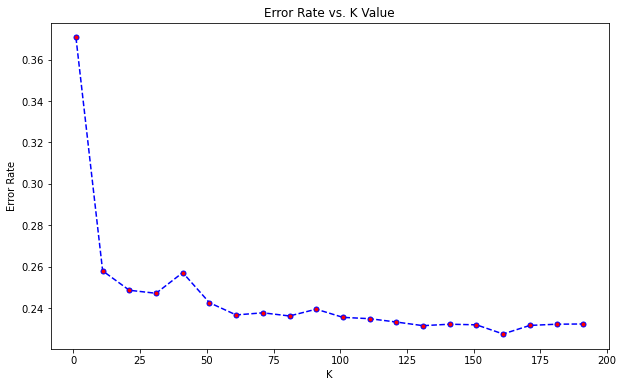

In [17]:
#plot graph of error rate against value of k
plt.figure(figsize=(10,6))
plt.plot(range(1, 201, 10), error_rate, color="blue", linestyle="dashed", marker="o", markerfacecolor="red", markersize=5)
plt.title("Error Rate vs. K Value")
plt.xlabel("K")
plt.ylabel("Error Rate")
plt.savefig('optimal_k.png')
plt.show()

In [18]:
X_train = train.drop(['gene_id', 'transcript_id', 'transcript_position', 'label'], axis = 1)
y_train = train['label']
X_test = test.drop(['gene_id', 'transcript_id', 'transcript_position', 'label'], axis = 1)
y_test = test['label']

In [19]:
#fit KNN model where k = 60
k = 60
knn = KNeighborsClassifier(n_neighbors = k, n_jobs=-1).fit(X_train, y_train)

#predict on test set, with results and metrics shown
pred_y = knn.predict(X_test)
cm = pd.DataFrame(confusion_matrix(pred_y, y_test))
cm.columns = ['True Y=0','True Y=1']
cm.index = ['Predicted Y=0','Predicted Y=1']
display(cm)
specificity = cm.iloc[0, 0]/(cm.iloc[0, 0] + cm.iloc[1, 0])
print("Accuracy:",round(accuracy_score(y_test, pred_y),4))
print('Precision:', round(precision_score(y_test, pred_y),4))
print('Specificity:', round(specificity,4))
print('Recall',round(recall_score(y_test,pred_y),4))
print('F1-Score:', round(f1_score(y_test,pred_y),4))
print('AUC:',round(roc_auc_score(y_test, pred_y),4))

,True Y=0,True Y=1
Predicted Y=0,23900,7138
Predicted Y=1,5499,21508


Accuracy: 0.7823
Precision: 0.7964
Specificity: 0.813
Recall 0.7508
F1-Score: 0.7729
AUC: 0.7819


In [23]:
print("Accuracy: ", round(accuracy_score(y_test, pred_y), 4))
print(classification_report(y_test, pred_y))

Accuracy:  0.7823
              precision    recall  f1-score   support

           0       0.77      0.81      0.79     29399
           1       0.80      0.75      0.77     28646

    accuracy                           0.78     58045
   macro avg       0.78      0.78      0.78     58045
weighted avg       0.78      0.78      0.78     58045



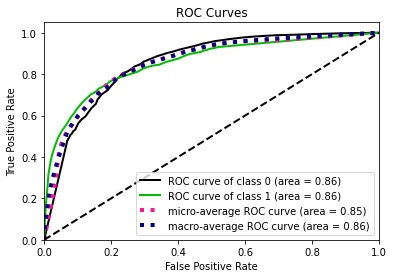

In [24]:
y_probas = knn.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas)
plt.savefig('ROC.png')
plt.show()

In [25]:
print(roc_auc_score(y_test, pred_y))
precision, recall, thresholds = precision_recall_curve(y_test, pred_y)
print(auc(recall, precision))

0.7818865901939541
0.8350900179901428


In [76]:
result = test[['transcript_id', 'transcript_position']]
score = [prob[1] for prob in y_probas]
result['score'] = score

<ipython-input-76-71fb7929d70b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['score'] = score


In [77]:
result.head()

,transcript_id,transcript_position,score
18,ENST00000000412,355,0.000000
19,ENST00000000412,367,0.583333
20,ENST00000000412,496,0.383333
21,ENST00000000412,501,0.783333
22,ENST00000000412,547,0.550000


In [80]:
result[result['transcript_id'] == 'ENST00000389680']

,transcript_id,transcript_position,score


In [79]:
result.to_csv('siitus_dataset0_1.csv', index = False)

In [46]:
dataset1 = load_data_json_file('/Users/chaeseong/Desktop/dsa4262/class8-intermediateSubmissionDeta/dataset1.json')

In [26]:
X = df_new.drop(['gene_id', 'transcript_id', 'transcript_position', 'label'], axis = 1)
y = df_new['label']

In [31]:
k = 60
model = KNeighborsClassifier(n_neighbors = k, n_jobs=-1)

In [32]:
model.fit(X, y)

KNeighborsClassifier(n_jobs=-1, n_neighbors=60)

In [33]:
import pickle

In [34]:
pickle.dump(model, open('model.sav', 'wb'))

In [ ]:
#pickled_model = pickle.load(open('model.sav', 'rb'))

In [34]:
dataset1.head()

,transcript_id,transcript_position,dwelling_time_before,sd_before,mean_before,dwelling_time_current,sd_current,mean_current,dwelling_time_after,sd_after,mean_after,nucleotide_before,nucleotide_current,nucleotide_after
0,ENST00000000233,244,0.008722,3.990545,123.090909,0.010218,6.716545,125.503030,0.006773,3.999745,80.060606,AAGAC,AGACC,GACCA
1,ENST00000000233,261,0.006292,2.849892,109.027711,0.007084,3.197289,107.190964,0.007168,2.686892,94.572289,CAAAC,AAACT,AACTG
2,ENST00000000233,316,0.007237,2.782710,105.440237,0.007050,3.463964,98.539053,0.007141,2.083775,88.985799,GAAAC,AAACA,AACAG
3,ENST00000000233,332,0.010299,6.042386,129.304348,0.008195,2.733641,97.320652,0.005806,2.252565,89.350000,AGAAC,GAACA,AACAT
4,ENST00000000233,368,0.011535,6.031751,118.000000,0.012108,5.748927,121.485876,0.009484,3.958192,85.220904,AGGAC,GGACA,GACAA


In [47]:
dataset1 = one_hot_encode_nucleotide_dataframe(dataset1)
X1 = dataset1.drop(['transcript_id', 'transcript_position'], axis = 1)
y1_prob = model.predict_proba(X1)

In [53]:
siitus_dataset1_1 = dataset1[['transcript_id', 'transcript_position']]
score = [prob[1] for prob in y1_prob]
siitus_dataset1_1['score'] = score

siitus_dataset1_1.to_csv('siitus_dataset1_1.csv', index = False)

<ipython-input-53-8520daad78ee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  siitus_dataset1_1['score'] = score


In [54]:
siitus_dataset1_1

,transcript_id,transcript_position,score
0,ENST00000000233,244,0.433333
1,ENST00000000233,261,0.000000
2,ENST00000000233,316,0.000000
3,ENST00000000233,332,0.350000
4,ENST00000000233,368,0.283333
...,...,...,...
90805,ENST00000641784,3122,0.950000
90806,ENST00000641784,3142,0.300000
90807,ENST00000641784,3224,0.916667
90808,ENST00000641784,3243,0.033333


In [81]:
siitus_dataset1_1[siitus_dataset1_1['transcript_id'] == 'ENST00000389680']

,transcript_id,transcript_position,score,score2,eval
59435,ENST00000389680,103,0.750000,0.082921,0
59436,ENST00000389680,166,0.000000,0.061655,1
59437,ENST00000389680,179,0.000000,0.076361,1
59438,ENST00000389680,204,0.000000,0.100867,1
59439,ENST00000389680,218,0.266667,0.086374,1
59440,ENST00000389680,266,0.000000,0.088288,1
59441,ENST00000389680,330,0.566667,0.173150,0
59442,ENST00000389680,350,0.000000,0.282311,1
59443,ENST00000389680,360,0.316667,0.239180,1
59444,ENST00000389680,371,0.000000,0.240759,1


In [49]:
dataset2 = load_data_json_file('/Users/chaeseong/Desktop/dsa4262/class8-intermediateSubmissionDeta/dataset2.json')

In [50]:
dataset2 = one_hot_encode_nucleotide_dataframe(dataset2)
X2 = dataset2.drop(['transcript_id', 'transcript_position'], axis = 1)
y2_prob = model.predict_proba(X2)

In [55]:
siitus_dataset2_1 = dataset2[['transcript_id', 'transcript_position']]
score = [prob[1] for prob in y2_prob]
siitus_dataset2_1['score'] = score

siitus_dataset2_1.to_csv('siitus_dataset2_1.csv', index = False)

<ipython-input-55-494d4ae5ce76>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  siitus_dataset2_1['score'] = score
